In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import sympy  as sp
import numpy  as np
import mpmath as mp
import matplotlib.pyplot as plt
import os

from scipy.stats import wasserstein_distance
from scipy.signal import find_peaks

In [19]:
TARGET = 'x'
TEST   = 2

In [20]:
tables  = [os.path.join('files', file) for file in os.listdir('files') if '.csv' in file]
tables

['files/test_1_x.csv', 'files/test_2_x.csv']

In [21]:
df = pd.read_csv(f'files/test_{TEST}_{TARGET}.csv')
df

,time,e,ay,wx,wy,roll,yaw,wz,pitch,ax,az
0,0.272000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.602000,0.0,-498.0,0.0,-1.0,0.0,0.0,1.0,0.0,-15.0,27.0
2,0.612000,0.0,-498.0,0.0,-1.0,0.0,0.0,1.0,0.0,-15.0,27.0
3,0.622000,0.0,-498.0,0.0,-1.0,0.0,0.0,1.0,0.0,-15.0,27.0
4,0.632000,0.0,-498.0,0.0,-1.0,0.0,0.0,1.0,0.0,-15.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...
26316,353.221985,0.0,-499.0,0.0,0.0,3061.0,34879.0,0.0,-8643.0,-15.0,28.0
26317,353.231995,0.0,-498.0,-1.0,0.0,3061.0,34880.0,0.0,-8643.0,-16.0,28.0
26318,353.242004,0.0,-497.0,-1.0,0.0,3061.0,34880.0,0.0,-8643.0,-15.0,27.0
26319,353.261993,0.0,-498.0,1.0,0.0,3061.0,34880.0,1.0,-8643.0,-15.0,27.0


# VISUALIZAÇÃO GERAL SENSORIAL

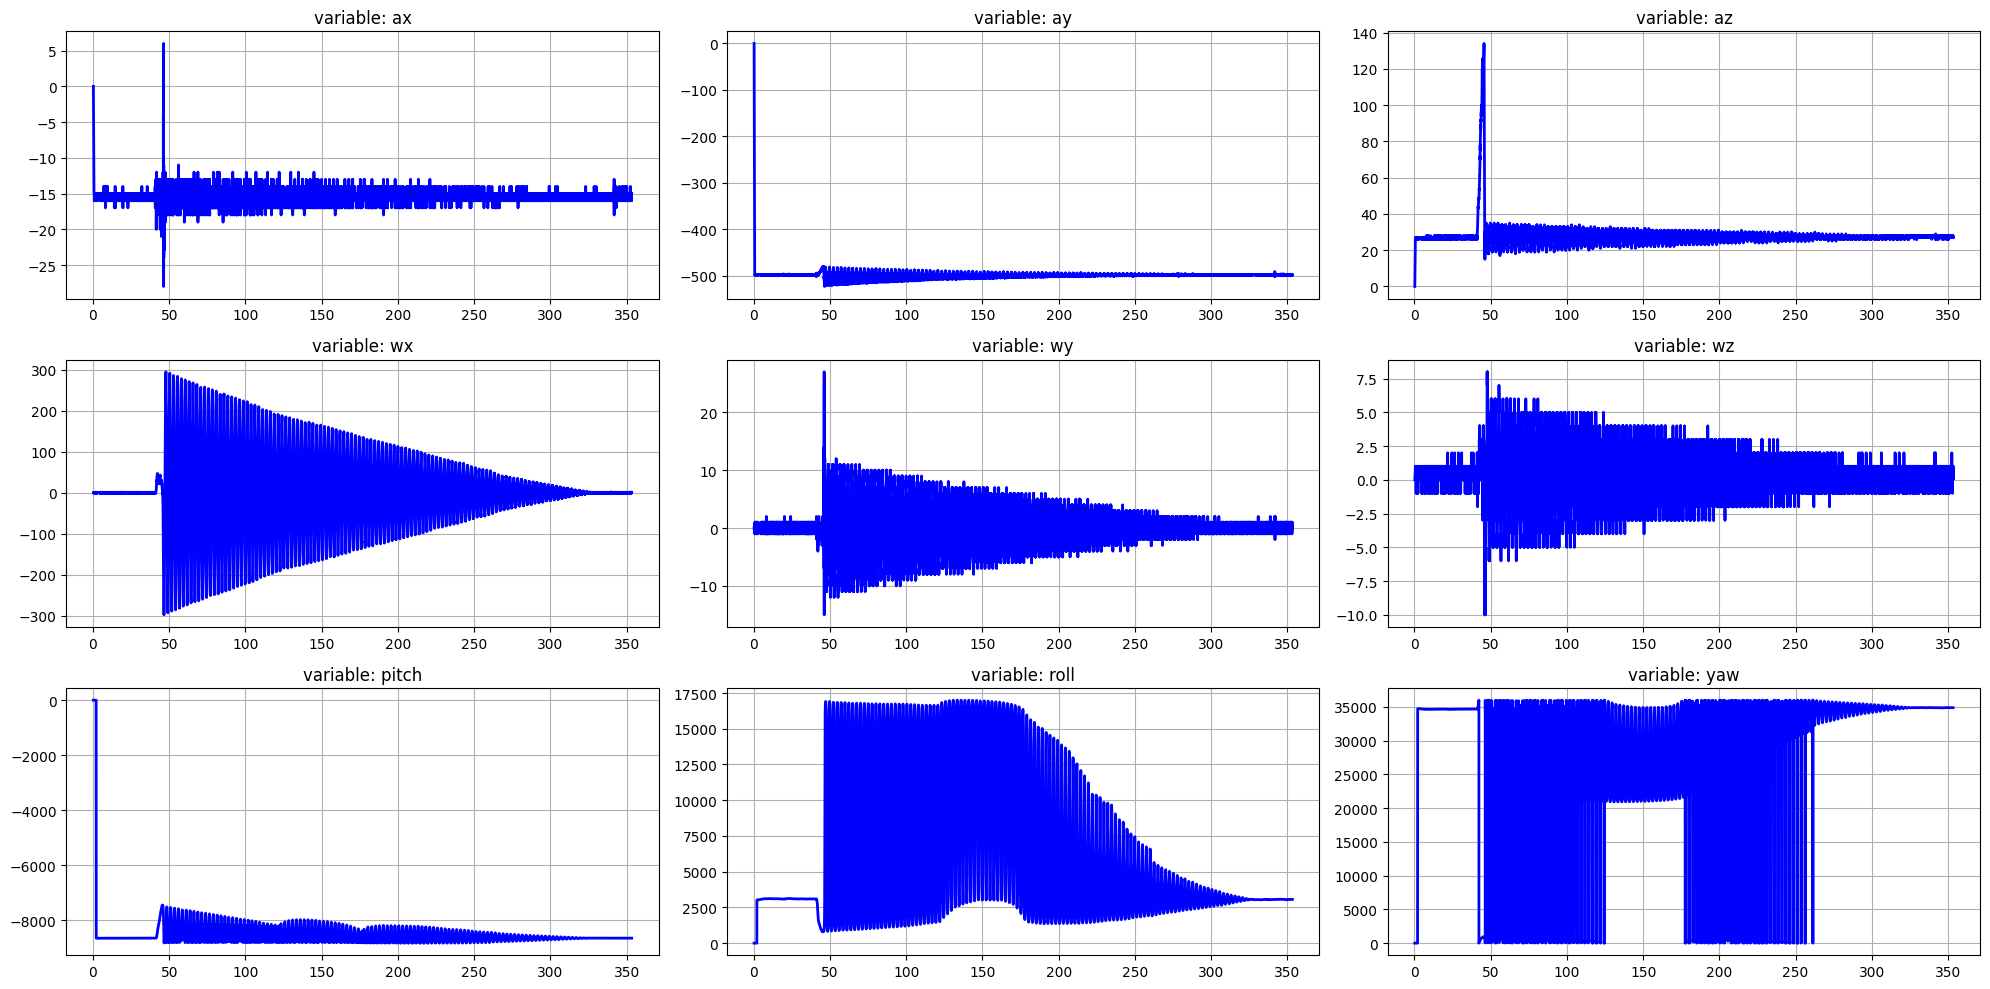

In [22]:
def plotAll(df, limits=None):
    limits = list(limits) if limits is not None else [None, None]

    if limits[0] is None:
        limits[0] = 0

    if limits[1] is None:
        limits[1] = df.time.values[-1]

    target = df.loc[(df.time >= limits[0]) & (df.time <= limits[1])]

    plt.figure(figsize=(20, 10))
    for i, key in enumerate(['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'pitch', 'roll', 'yaw']):
        plt.subplot(3, 3, i+1)
        plt.plot(target.time, target[key], color='blue', linewidth=2)
        plt.title(f'variable: {key}'), plt.grid()

    plt.tight_layout()
    plt.show()


plotAll(df)

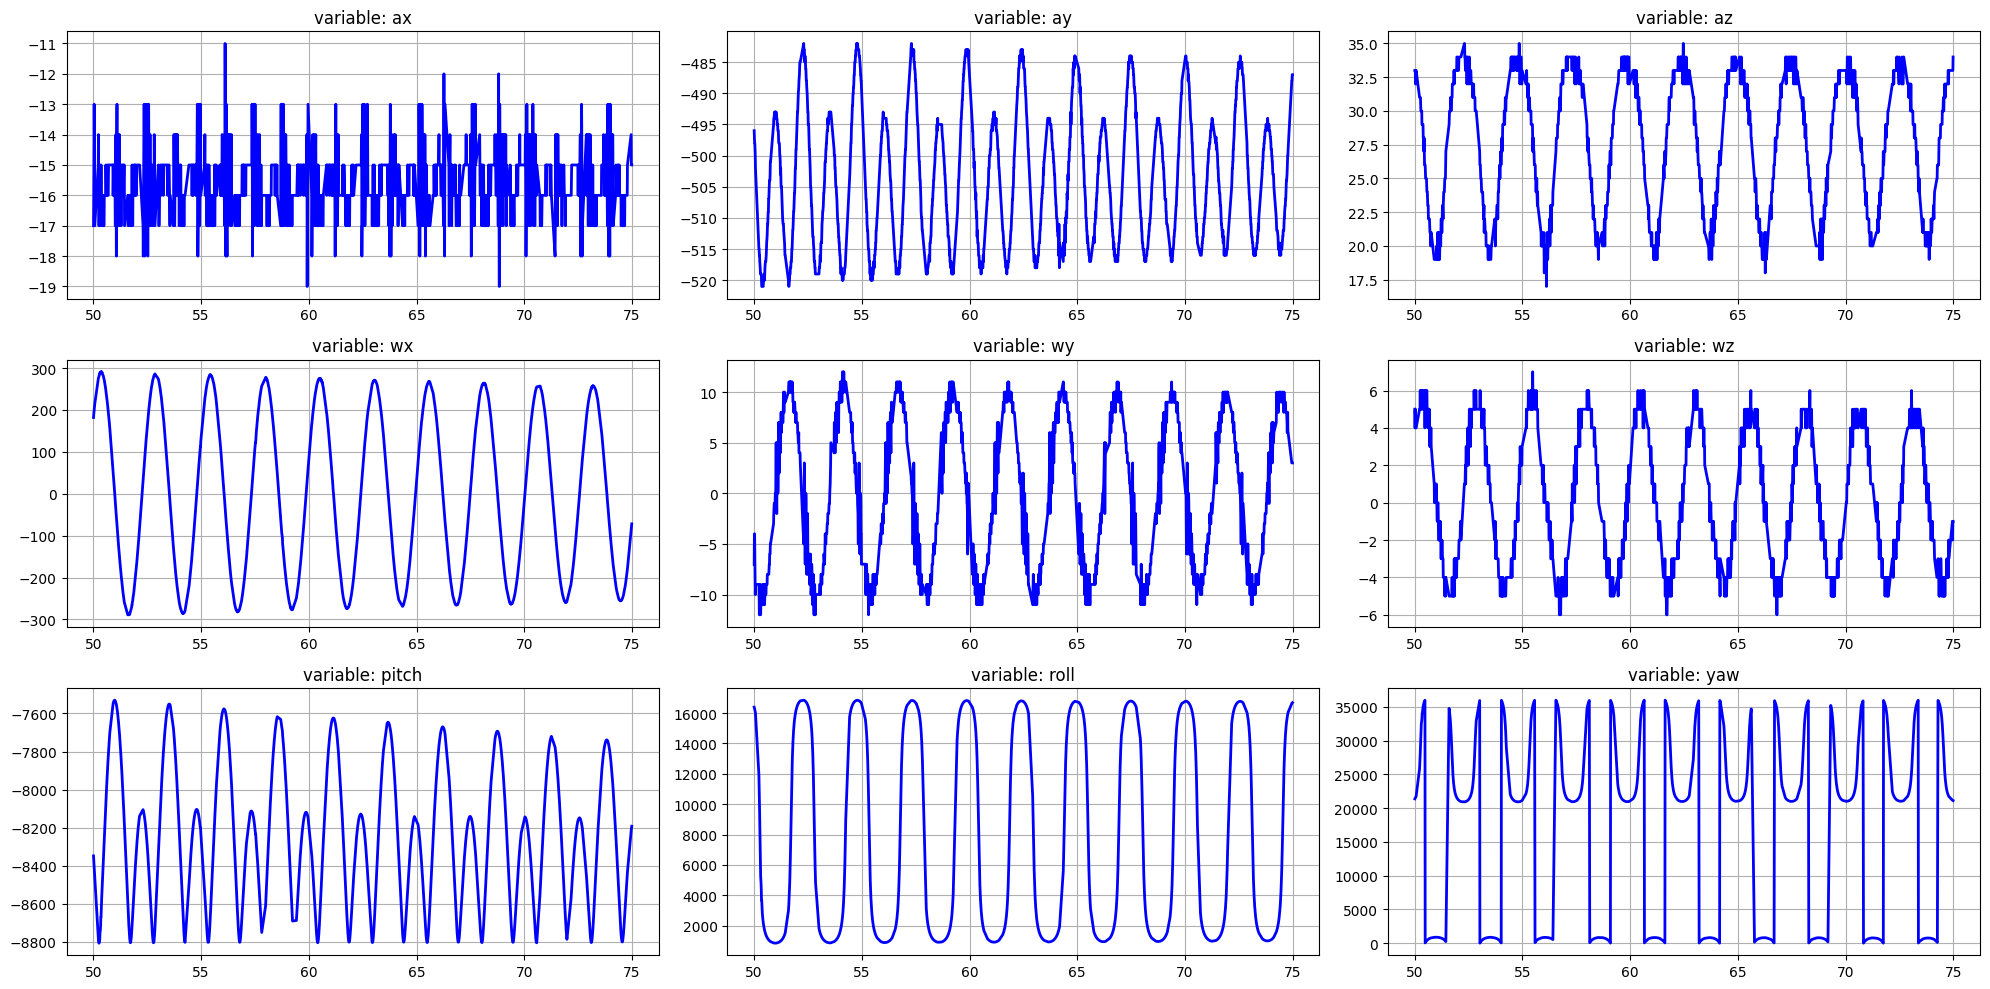

In [23]:
plotAll(df, limits=(50, 75))

# VISUALIZAÇÃO FOCADA

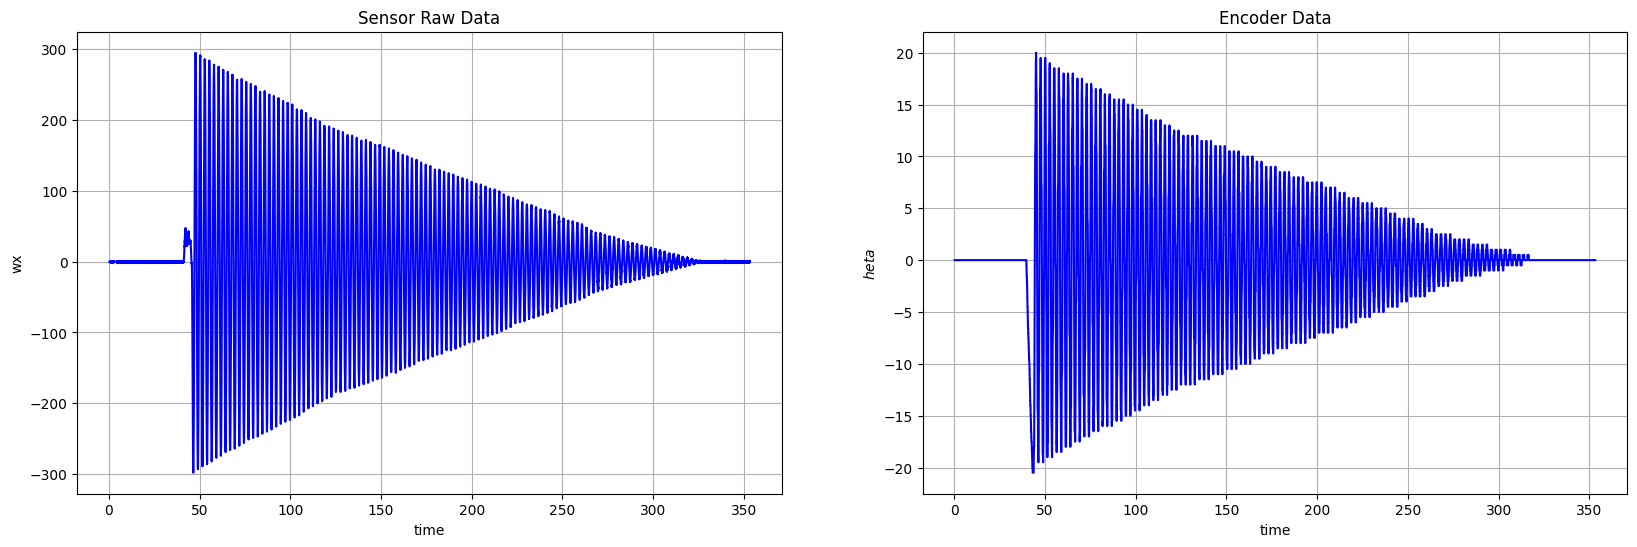

In [24]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(df.time, df[f'w{TARGET}'], color='blue')
plt.title('Sensor Raw Data')
plt.xlabel('time'); plt.ylabel(f'w{TARGET}')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.e, color='blue')
plt.title('Encoder Data')
plt.xlabel('time'); plt.ylabel('$\theta$')
plt.grid()

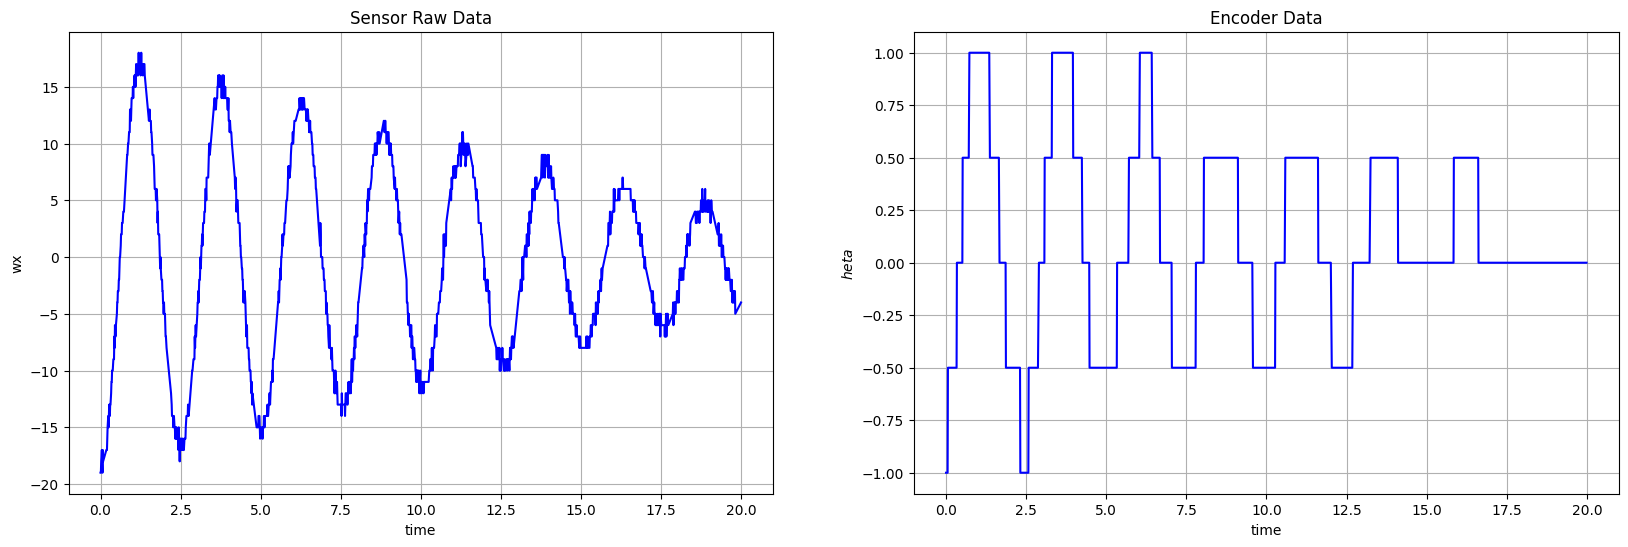

In [25]:
target = df.loc[(df.time > 300) & (df.time < 320)].copy()
target['time'] = target.time.values - target.time.values[0]

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(target.time, target[f'w{TARGET}'], color='blue')
plt.title('Sensor Raw Data')
plt.xlabel('time'); plt.ylabel(f'w{TARGET}')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(target.time, target.e, color='blue')
plt.title('Encoder Data')
plt.xlabel('time'); plt.ylabel('$\theta$')
plt.grid()

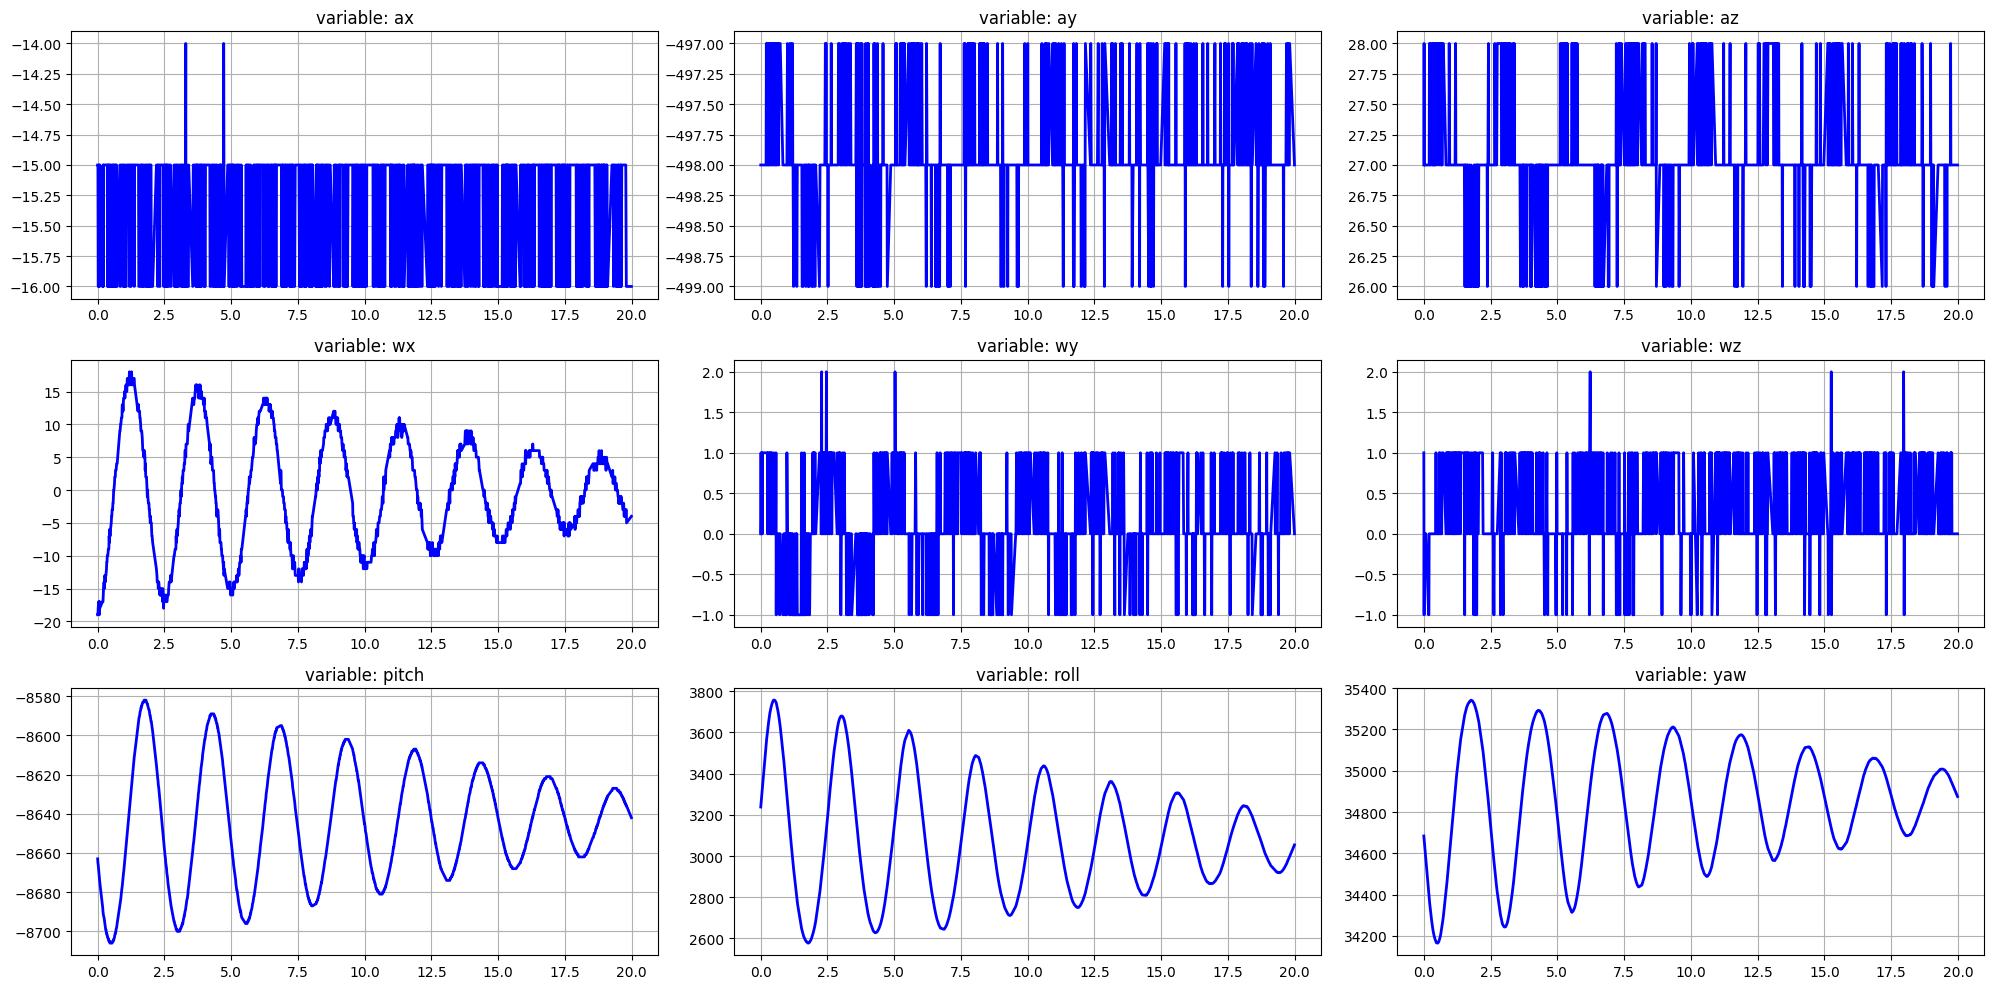

In [26]:
plotAll(target)

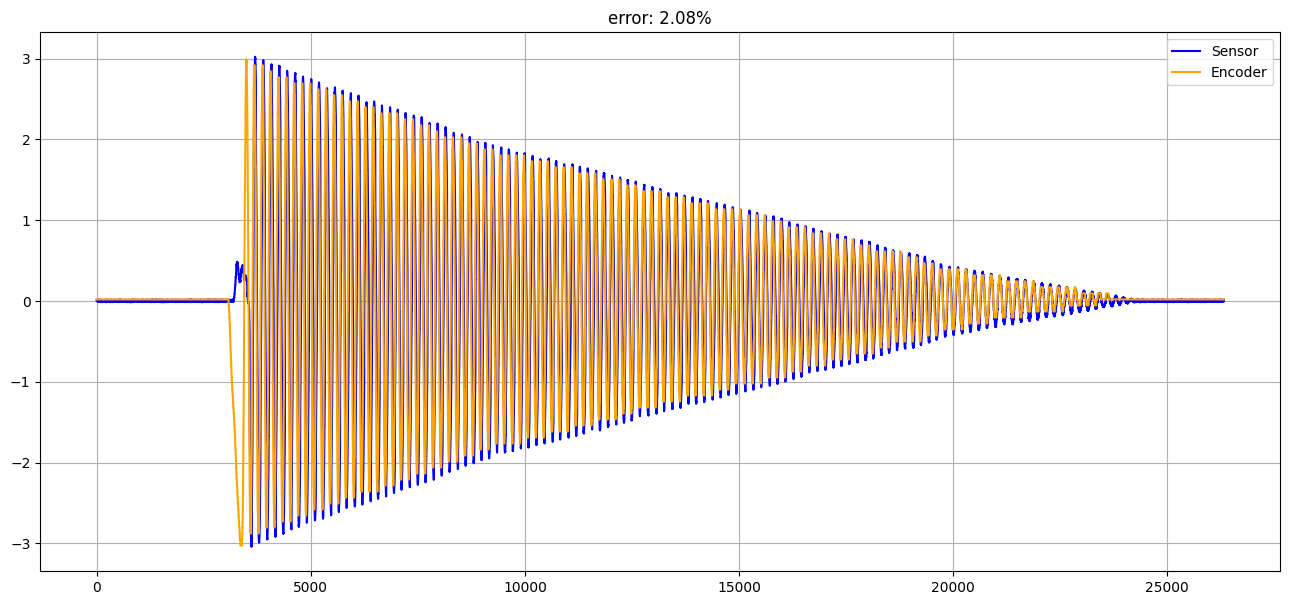

In [27]:
def normalize(data):
    return np.array(data - np.mean(data))/np.std(data)

def getMAPE(real, values):
    return float(np.mean(np.abs((real - values) / real)).round(6))

def compare(data1, data2, phase=0, plot=False):
    data1 = normalize(data1)
    data2 = normalize(data2)
    score = wasserstein_distance(data1, data2)
    data2 = data2[phase:]

    n_samples = min(len(data1), len(data2))
    samples1 = np.linspace(0, len(data1)-1, n_samples, dtype=int)
    samples2 = np.linspace(0, len(data2)-1, n_samples, dtype=int)

    data1 = data1[samples1]
    data2 = data2[samples2]

    if plot:
        plt.figure(figsize=(16, 7))
        plt.plot(data1, color='blue', label='Sensor')
        plt.plot(data2, color='orange',  label='Encoder')
        plt.title(f'error: {score*100:.2f}%')
        plt.legend(), plt.grid()
        plt.show()

    return (data1, data2, score)


result = compare(df.wx, df.e, plot=True)

In [28]:
getMAPE(df.wx.values, df.e.values)

/tmp/ipykernel_7942/247517651.py:5: RuntimeWarning: divide by zero encountered in divide
  return float(np.mean(np.abs((real - values) / real)).round(6))
/tmp/ipykernel_7942/247517651.py:5: RuntimeWarning: invalid value encountered in divide
  return float(np.mean(np.abs((real - values) / real)).round(6))


nan

# MATEMÁTICA

In [29]:
L = 1

### Erro Percentual Absoluto Médio (MAPE).
Para cada elemento correspondente nos dois arrays, você calcula a diferença absoluta, divide pelo valor real e multiplica por 100. Depois, tira a média desses valores.